In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from scipy.stats import chi2

from shapkit.generate_samples import generate_sample
from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo import MonteCarloShapley
from shapkit.stochastic_gradient import SGDshapley

%load_ext autoreload
%autoreload 2

# Generate dataset

In [2]:
d = 300
rho = 0

# Train and Test dataset
n_samples = 10000
X = generate_sample(d, rho, n_samples)
y = np.zeros(len(X))
for i in range(len(X)):
    phi_x = np.sqrt(.5 * np.pi) * np.exp(-0.5 * X.values[i] ** 2)
    y[i] = np.prod(phi_x)

In [3]:
# Number of coalitions
d = X.shape[1]
n = 2**d - 2
def fc(x):
    phi_x = np.sqrt(.5 * np.pi) * np.exp(-0.5 * x ** 2)
    return np.prod(phi_x)
print("dimension = {0} ; nb of coalitions = {1}".format(str(d), str(n)))

dimension = 16 ; nb of coalitions = 65534


# Experiments 

## Start computation

In [ ]:
%%time

n_iter = 200 * d # nb of reward calls
n_expe = 1
dict_results = {"MC": np.empty((n_expe, int(n_iter/d))),
                "cst step 0.01": np.empty((n_expe, int(n_iter/d))),
                "sqrt step 0.1": np.empty((n_expe, int(n_iter/d)))}

for i in range(n_expe):
    print()
    print("Expe n°"+str(i))
    # set the game
    too_close = True
    while too_close == True:
        idx_r, idx_x = np.random.choice(np.arange(len(X)), size=2, replace=False)
        r = X.iloc[idx_r,:]
        x = X.iloc[idx_x,:]
        r_pred = fc(r.values)
        x_pred = fc(x.values)
        if np.abs(x_pred - r_pred) > 0:
            too_close = False

    print(x_pred, r_pred)

    # true Shapley Values
    if d <= 20:
        true_shap = ShapleyValues(x=x, fc=fc, r=r)
    else:
        true_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=5000)
    print("True Shapley ✓")

    # Monte Carlo estimation
    mc_inspector = inspector(x_min=true_shap, verbose=False)
    mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=int(n_iter/d),
                                callback=mc_inspector)
    dict_results["MC"][i,:] = mc_inspector.err
    print("Monte Carlo Shapley ✓")

    # SGD estimations
    C = y.max()
    D = C * np.sqrt(d)
    d = len(x)
    sgd_shap = SGDshapley(d, C)
    parameters = {"cst step 0.01": {"γ":0.00001, "step_type":"constant", "sampling": True},
                  "sqrt step 0.1": {"γ":0.0001, "step_type":"sqrt", "sampling":True}}
    # Start calculation of all methods
    for method, param in parameters.items():
        sgd_inspector = inspector(x_min=true_shap, verbose=False)
        sgd_shap.sgd(x=x, fc=fc, r=r, n_iter=n_iter, γ=param["γ"],
                     step_type=param["step_type"], callback=sgd_inspector,
                     sampling=param["sampling"], D=D, iter_proj=1000)
        dict_results[method][i,:] = sgd_inspector.err
        print(method + " ✓")

# Save results
# for method in dict_results.keys():
#     np.save("results_regression/dimension_300/"+method, dict_results[method])
# print()
# print("Saved ! ✓")

## Load results stored (if needed)

In [4]:
methods = ["MC","cst step 0.1","cst step 0.01",
           "cst step 0.001","sqrt step 1","sqrt step 0.1",
           "sqrt step 0.01","inv step 10","inv step 1","inv step 0.1"]
dict_results = dict()
for method in methods:
    dict_results[method] = np.load("../results_classification/dimension_300/"+method+".npy")

# Plots

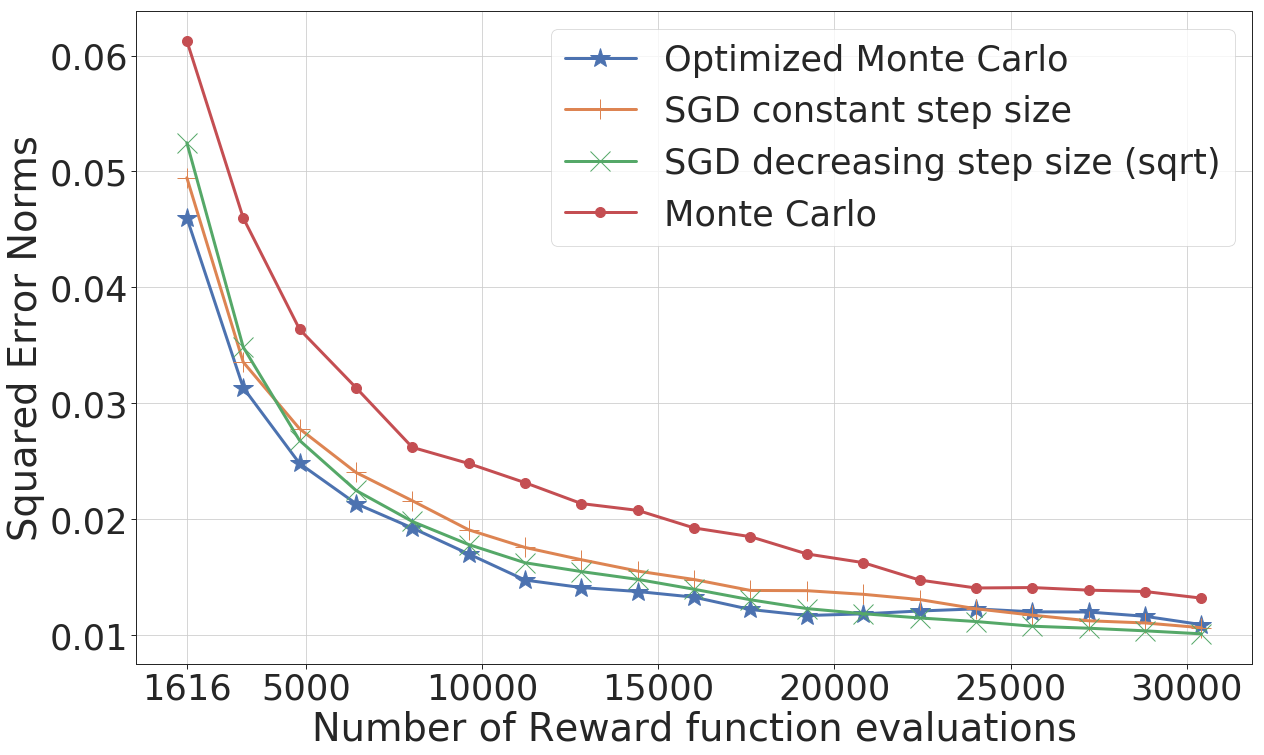

In [5]:
n_iter = dict_results["MC"].shape[1]

sns.set_style("ticks")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(20,12))
import itertools
marker = itertools.cycle(('*', '+', 'x', '.', 'v'))

for method in dict_results.keys():
    # n_iter = dict_results[method].shape[1]
    idx = np.arange(0,n_iter,10)
    if method in ["MC","sqrt step 0.1","cst step 0.01"]:
        if method == "MC":
            label = "Optimized Monte Carlo"
        elif method == "sqrt step 0.1":
            label = "SGD decreasing step size (sqrt)"
        elif method == "cst step 0.01":
            label = "SGD constant step size"
        plt.plot(idx*d + d,
                 dict_results[method].mean(axis=0)[idx],
                 label=label,
                 marker=next(marker),
                 markersize=1)
# Classical MC
plt.plot(idx*d + d,
         dict_results["MC"].mean(axis=0)[idx // 2],
         label="Monte Carlo",
         marker=next(marker),
         markersize=1)
plt.xlabel("Number of Reward function evaluations")
plt.xticks(idx*d + d)
# plt.xscale('log')
plt.ylabel("Squared Error Norms")
plt.legend(loc='best')
plt.grid(True)
plt.title("Classification - Dimension 300")
# plt.savefig("results_classification/dimension_300/plots/results.png", format="png")
plt.show()